In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/IoT/data-science-bowl-2018.zip

Archive:  /content/drive/MyDrive/IoT/data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [3]:
!mkdir -p /content/train
!unzip /content/stage1_train.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/

In [4]:
!pip install stardist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.0 MB/s eta 0:00:00


In [5]:
!pip install "numpy<2" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have nu

In [1]:
import numpy as np
print(np.__version__)   # phải là 1.26.x
import stardist
stardist.__version__

1.26.4


'0.9.1'

In [2]:
ROOT = "content/train"

In [3]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm

import imageio.v2 as imageio
from csbdeep.utils import normalize

ROOT = "/content/train"

X, Y = [], []

subfolders = sorted(glob(ROOT + "/*/"))

print("Found", len(subfolders), "subfolders")

for sub in subfolders:
    img_path = glob(os.path.join(sub, "images", "*.png"))[0]
    mask_paths = sorted(glob(os.path.join(sub, "masks", "*.png")))

    # -------- LOAD IMAGE --------
    img_raw = imageio.imread(img_path)

    if img_raw.ndim == 3:
        img_raw = np.mean(img_raw[..., :3], axis=-1)

    img = normalize(img_raw, 1, 99.8)

    # -------- BUILD INSTANCE MASK --------
    h, w = img.shape
    inst_mask = np.zeros((h, w), dtype=np.int32)

    obj_id = 1
    for mp in mask_paths:
        m = imageio.imread(mp)
        if m.ndim == 3:
            m = m[..., 0]

        m = (m > 0).astype(np.uint8)
        inst_mask[m == 1] = obj_id
        obj_id += 1

    X.append(img)
    Y.append(inst_mask)


print("Loaded", len(X), "images")
print("Example:", X[0].shape, Y[0].shape)



Found 670 subfolders
Loaded 670 images
Example: (256, 256) (256, 256)


In [ ]:
import numpy as np
import random
import cv2  # nếu chưa có thì !pip install opencv-python-headless

def augmenter(x, y):
    assert x.shape[:2] == y.shape[:2]

    # ----- Flip ngang -----
    if random.random() < 0.5:
        x = np.flip(x, axis=1)
        y = np.flip(y, axis=1)

    # ----- Flip dọc -----
    if random.random() < 0.5:
        x = np.flip(x, axis=0)
        y = np.flip(y, axis=0)

    # ----- Rotate 0/90/180/270 -----
    k = random.randint(0, 3)
    x = np.rot90(x, k)
    y = np.rot90(y, k)

    # ----- Zoom nhẹ (crop + resize) -----
    if random.random() < 0.5:
        h, w = x.shape[:2]
        scale = random.uniform(0.85, 1.0)
        nh, nw = int(h * scale), int(w * scale)
        top  = random.randint(0, h - nh)
        left = random.randint(0, w - nw)

        x_crop = x[top:top+nh, left:left+nw]
        y_crop = y[top:top+nh, left:left+nw]

        x = cv2.resize(x_crop, (w, h), interpolation=cv2.INTER_LINEAR)
        y = cv2.resize(y_crop, (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int32)

    # ----- Gamma / độ tương phản -----
    if random.random() < 0.5:
        gamma = random.uniform(0.8, 1.2)
        x = x.astype(np.float32)
        x = x - x.min()
        if x.max() > 0:
            x = x / x.max()
        x = np.power(x, gamma)

    # ----- Gaussian noise -----
    if random.random() < 0.5:
        noise_std = random.uniform(0.0, 0.05)
        noise = np.random.normal(0, noise_std, size=x.shape).astype(np.float32)
        x = x.astype(np.float32) + noise
        x = np.clip(x, 0.0, 1.0)

    return x.astype('float32'), y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

from stardist.models import Config2D, StarDist2D


config = Config2D(
    n_rays=64,
    grid=(2,2),
    train_patch_size=(256,256),

    # tăng độ sâu + số filter của U-Net
    unet_n_depth=4,           # mặc định 3 → sâu hơn, học được pattern phức tạp hơn
    unet_n_filter_base=64,    # mặc định 32 → nhiều kênh feature hơn

    # training hyperparams
    train_batch_size=4,       # nếu GPU đủ, có thể tăng lên 8
    train_learning_rate=2e-4  # nhỏ hơn mặc định 3e-4 → học “mượt” hơn

)

model = StarDist2D(config=config, name="stardist_model", basedir="models")

history = model.train(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=250,
    steps_per_epoch=250,
    augmenter=augmenter
)





base_model.py (203): output path for model already exists, files may be overwritten: /content/models/stardist_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 243ms/step - dist_dist_iou_metric: 0.1350 - dist_loss: 11.4985 - dist_relevant_mae: 11.4980 - dist_relevant_mse: 256.1326 - loss: 2.7046 - prob_kld: 0.3235 - prob_loss: 0.4049 - val_dist_dist_iou_metric: 0.3053 - val_dist_loss: 6.4584 - val_dist_relevant_mae: 6.3917 - val_dist_relevant_mse: 97.1965 - val_loss: 1.4906 - val_prob_kld: 0.1443 - val_prob_loss: 0.2138 - learning_rate: 2.0000e-04
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - dist_dist_iou_metric: 0.3371 - dist_loss: 7.1418 - dist_relevant_mae: 7.1404 - dist_relevant_mse: 110.4821 - loss: 1.6514 - prob_kld: 0.1426 - prob_loss: 0.2231 - val_dist_dist_iou_metric: 0.4409 - val_dist_loss: 5.3752 - val_dist_relevant_mae: 5.3477 - val_dist_relevant_mse: 62.7158 - val_loss: 1.2287 - val_prob_kld: 0.0898 - val_prob_loss: 0.1592 - learning_rate: 2.0000e-04
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - dist_dist_i

<> (21): invalid escape sequence '\_'
<> (21): invalid escape sequence '\_'
ipython-input-893348904.py (21): invalid escape sequence '\_'


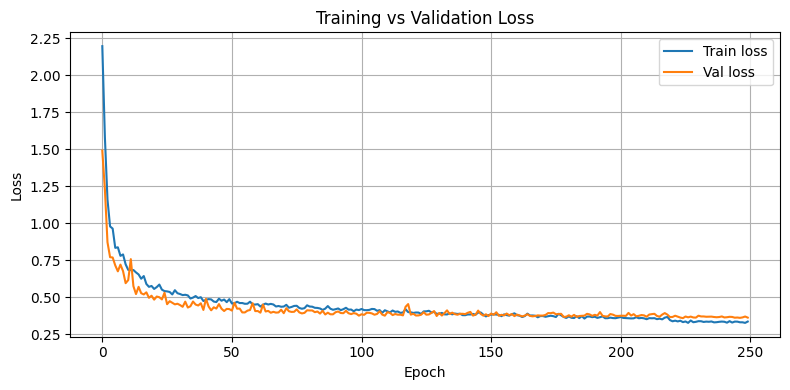

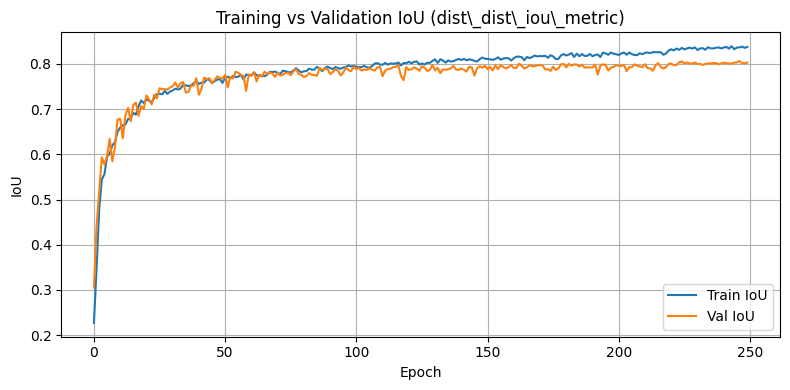

In [ ]:
import matplotlib.pyplot as plt

# ----- 1. Loss vs Val Loss -----
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- 2. "Accuracy": dist_dist_iou_metric vs val_dist_dist_iou_metric -----
plt.figure(figsize=(8,4))
plt.plot(history.history['dist_dist_iou_metric'], label='Train IoU')
plt.plot(history.history['val_dist_dist_iou_metric'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training vs Validation IoU (dist\_dist\_iou\_metric)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!mv /content/models /content/drive/MyDrive/IoT/

mv: cannot stat '/content/models': No such file or directory


In [ ]:
from stardist.models import StarDist2D

model = StarDist2D(
    config=None,
    name="stardist_model",
    basedir="/content/drive/MyDrive/IoT/models"
)

print("Model loaded ✓")



Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Model loaded ✓


In [ ]:
!unzip /content/drive/MyDrive/IoT/BubbleImages_.zip

Archive:  /content/drive/MyDrive/IoT/BubbleImages_.zip
   creating: frames/
  inflating: frames/frame_0001.png   
  inflating: frames/frame_0002.png   
  inflating: frames/frame_0003.png   
  inflating: frames/frame_0004.png   
  inflating: frames/frame_0005.png   
  inflating: frames/frame_0006.png   
  inflating: frames/frame_0007.png   
  inflating: frames/frame_0008.png   
  inflating: frames/frame_0009.png   
  inflating: frames/frame_0010.png   
  inflating: frames/frame_0011.png   
  inflating: frames/frame_0012.png   
  inflating: frames/frame_0013.png   
  inflating: frames/frame_0014.png   
  inflating: frames/frame_0015.png   
  inflating: frames/frame_0016.png   
  inflating: frames/frame_0017.png   
  inflating: frames/frame_0018.png   
  inflating: frames/frame_0019.png   
  inflating: frames/frame_0020.png   
  inflating: frames/frame_0021.png   
  inflating: frames/frame_0022.png   
  inflating: frames/frame_0023.png   
  inflating: frames/frame_0024.png   
  inflating:

Số bubble dự đoán: 85


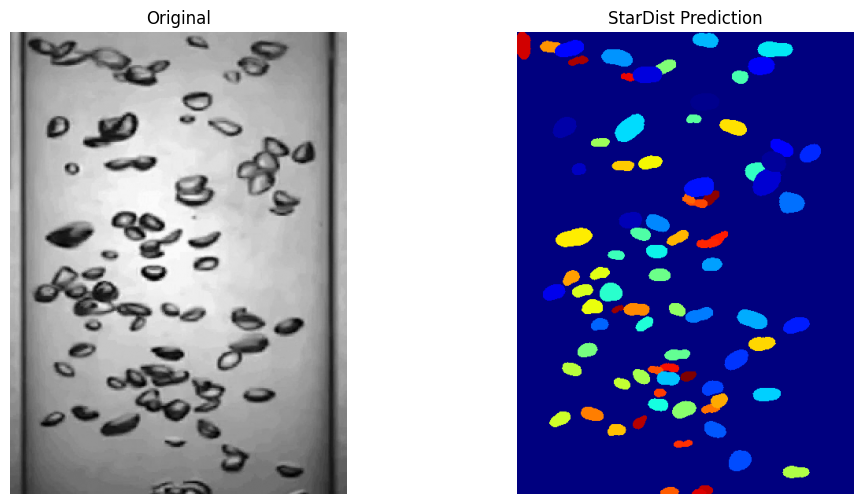

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0003.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


Số bubble dự đoán (labels.max): 85

=== Thông tin từng bubble ===
Bubble 1: area = 659.0 pixel, centroid = (238.1, 88.5)
Bubble 2: area = 655.0 pixel, centroid = (325.7, 164.7)
Bubble 3: area = 602.0 pixel, centroid = (60.0, 120.9)
Bubble 4: area = 506.0 pixel, centroid = (143.9, 239.2)
Bubble 5: area = 223.0 pixel, centroid = (78.2, 174.2)
Bubble 6: area = 897.0 pixel, centroid = (316.2, 191.1)
Bubble 7: area = 666.0 pixel, centroid = (165.2, 53.9)
Bubble 8: area = 457.0 pixel, centroid = (46.5, 330.9)
Bubble 9: area = 633.0 pixel, centroid = (309.9, 42.7)
Bubble 10: area = 461.0 pixel, centroid = (336.1, 146.7)
Bubble 11: area = 601.0 pixel, centroid = (66.5, 21.0)
Bubble 12: area = 763.0 pixel, centroid = (231.4, 197.2)
Bubble 13: area = 530.0 pixel, centroid = (354.3, 372.9)
Bubble 14: area = 479.0 pixel, centroid = (372.1, 154.0)
Bubble 15: area = 568.0 pixel, centroid = (278.2, 416.7)
Bubble 16: area = 406.0 pixel, centroid = (247.8, 452.6)
Bubble 17: area = 612.0 pixel, centroid

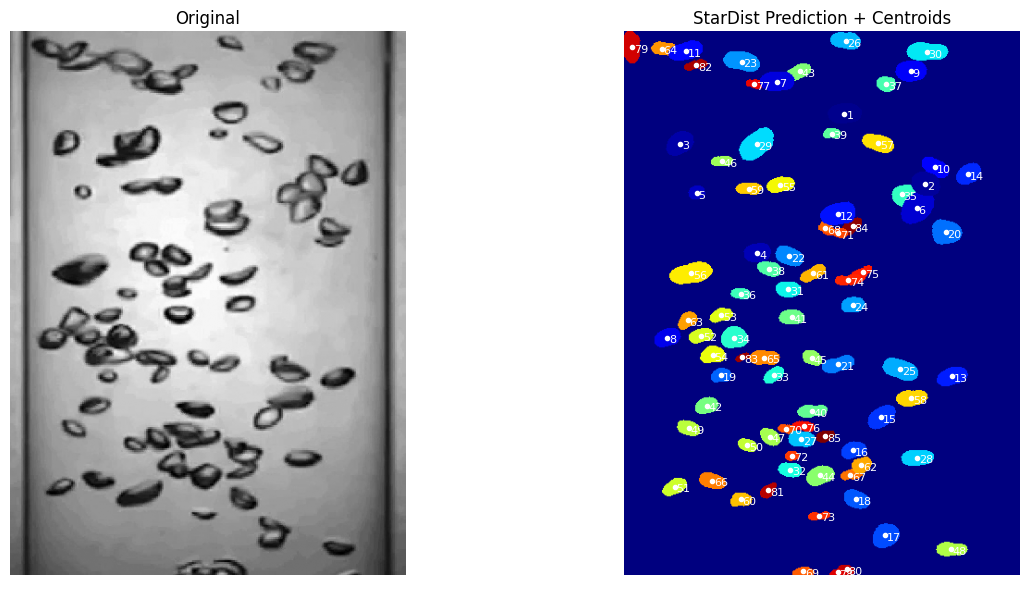

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize
from skimage.measure import regionprops  # 👈 THÊM IMPORT NÀY

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0003.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán (labels.max):", labels.max())

# ----- PHÂN TÍCH TỪNG BUBBLE -----
regions = regionprops(labels)  # tự bỏ background (label = 0)

areas = []
print("\n=== Thông tin từng bubble ===")
for i, r in enumerate(regions, start=1):
    area = r.area                     # diện tích theo số pixel
    cy, cx = r.centroid               # (row, col) = (y, x)
    areas.append(area)
    print(f"Bubble {i}: area = {area} pixel, centroid = ({cx:.1f}, {cy:.1f})")

total_area = np.sum(areas)
print("\nTổng số bubble (regionprops):", len(regions))
print("Tổng diện tích tất cả bubble:", total_area, "pixel")

# ----- VẼ KẾT QUẢ + MINH HỌA TRỰC QUAN -----
plt.figure(figsize=(14, 6))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

# Ảnh nhãn + centroid + ID
plt.subplot(1, 2, 2)
plt.title("StarDist Prediction + Centroids")
plt.imshow(labels, cmap="jet")
plt.axis("off")

for i, r in enumerate(regions, start=1):
    cy, cx = r.centroid
    # chấm centroid
    plt.plot(cx, cy, 'wo', markersize=3)
    # in ID cạnh centroid
    plt.text(cx + 2, cy + 2, str(i),
             color='white', fontsize=8, ha='left', va='center')

plt.tight_layout()
plt.show()


Số bubble dự đoán: 104


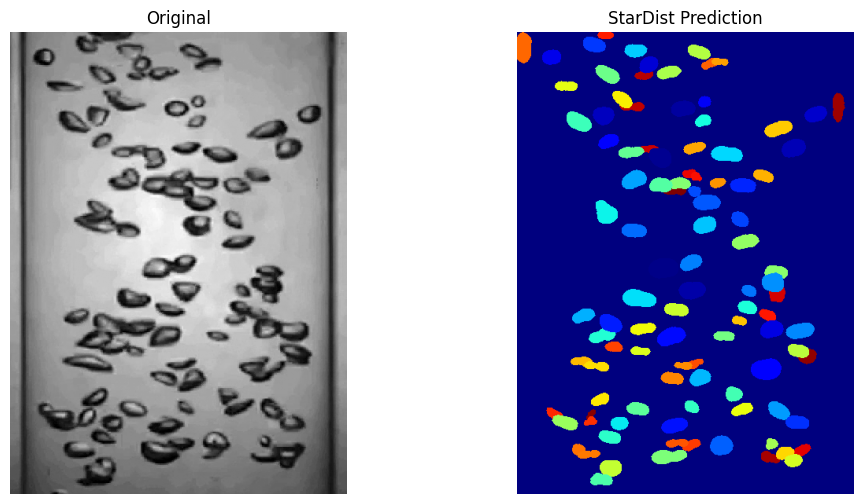

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0027.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


Số bubble dự đoán: 105


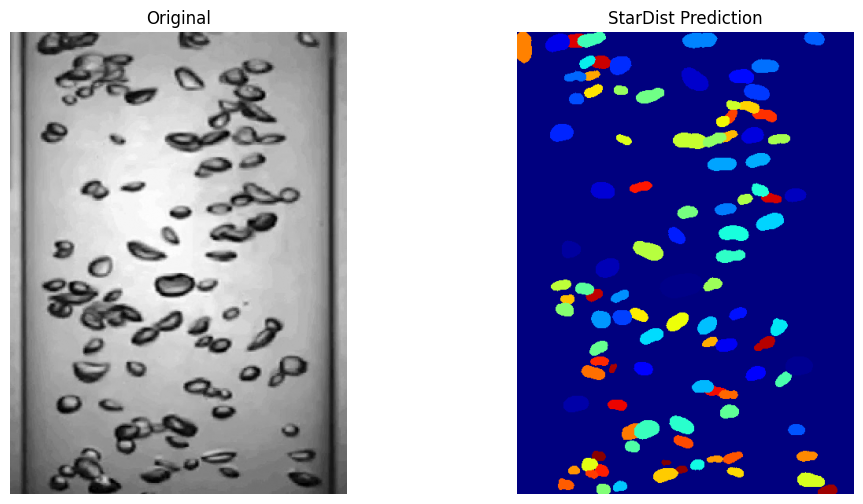

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0128.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


In [ ]:
import os
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize
from skimage.measure import regionprops

# ============================
#   THƯ MỤC INPUT / OUTPUT
# ============================
FRAME_DIR   = "/content/frames"
MASK_DIR    = "/content/output_masks"      # ảnh mask trắng/đen
LABELED_DIR = "/content/output_labeled"    # ảnh có số label + centroid
TXT_PATH    = "/content/bubble_areas.txt"  # file text lưu diện tích

os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(LABELED_DIR, exist_ok=True)

# ============================
#   MỞ FILE TEXT GHI KẾT QUẢ
# ============================
f = open(TXT_PATH, "w", encoding="utf-8")
f.write("filename,bubble_id,area_px,centroid_x,centroid_y\n")

# ============================
#   DUYỆT TOÀN BỘ ẢNH
# ============================
image_names = sorted([
    fn for fn in os.listdir(FRAME_DIR)
    if fn.lower().endswith((".png", ".jpg", ".jpeg"))
])

print("Found", len(image_names), "images")

for fname in image_names:
    path = os.path.join(FRAME_DIR, fname)

    # ----- LOAD IMAGE -----
    img = imageio.imread(path)

    # RGB → Grayscale nếu cần
    if img.ndim == 3:
        img = img[..., :3]
        img = np.mean(img, axis=-1)

    img_n = normalize(img, 1, 99.8)

    # ----- PREDICT -----
    labels, _ = model.predict_instances(img_n)
    print(f"{fname}: dự đoán {labels.max()} bubbles")

    # ============================
    # 1) LƯU ẢNH MASK (CHỈ BUBBLE)
    # ============================
    # mask nhị phân: 0 = nền, 255 = bubble
    mask_binary = (labels > 0).astype(np.uint8) * 255

    mask_name = os.path.splitext(fname)[0] + "_mask.png"
    mask_path = os.path.join(MASK_DIR, mask_name)
    imageio.imwrite(mask_path, mask_binary)

    # ============================
    # 2) TÍNH REGIONPROPS & GHI TEXT
    # ============================
    regions = regionprops(labels)

    # ============================
    # 3) VẼ ẢNH LABEL + CENTROID + ID
    # ============================
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.imshow(labels, cmap="jet")
    ax.axis("off")
    ax.set_title(f"{fname} - {len(regions)} bubbles")

    for i, r in enumerate(regions, start=1):
        area = r.area
        cy, cx = r.centroid  # (row, col) = (y, x)

        # ghi vào file text
        f.write(f"{fname},{i},{area},{cx:.2f},{cy:.2f}\n")

        # vẽ centroid + ID
        ax.plot(cx, cy, 'wo', markersize=3)
        ax.text(cx + 2, cy + 2, str(i),
                color='white', fontsize=8,
                ha='left', va='center')

    labeled_name = os.path.splitext(fname)[0] + "_labeled.png"
    labeled_path = os.path.join(LABELED_DIR, labeled_name)

    fig.savefig(labeled_path, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.close(fig)

# đóng file text
f.close()

print("\nĐã lưu:")
print(" - Ảnh mask  :", MASK_DIR)
print(" - Ảnh labeled:", LABELED_DIR)
print(" - File text  :", TXT_PATH)


Found 886 images
frame_0001.png: dự đoán 80 bubbles
frame_0002.png: dự đoán 80 bubbles
frame_0003.png: dự đoán 85 bubbles
frame_0004.png: dự đoán 85 bubbles
frame_0005.png: dự đoán 92 bubbles
frame_0006.png: dự đoán 84 bubbles
frame_0007.png: dự đoán 93 bubbles
frame_0008.png: dự đoán 89 bubbles
frame_0009.png: dự đoán 88 bubbles
frame_0010.png: dự đoán 98 bubbles
frame_0011.png: dự đoán 98 bubbles
frame_0012.png: dự đoán 92 bubbles
frame_0013.png: dự đoán 103 bubbles
frame_0014.png: dự đoán 88 bubbles
frame_0015.png: dự đoán 96 bubbles
frame_0016.png: dự đoán 103 bubbles
frame_0017.png: dự đoán 96 bubbles
frame_0018.png: dự đoán 98 bubbles
frame_0019.png: dự đoán 101 bubbles
frame_0020.png: dự đoán 104 bubbles
frame_0021.png: dự đoán 109 bubbles
frame_0022.png: dự đoán 109 bubbles
frame_0023.png: dự đoán 116 bubbles
frame_0024.png: dự đoán 100 bubbles
frame_0025.png: dự đoán 113 bubbles
frame_0026.png: dự đoán 112 bubbles
frame_0027.png: dự đoán 104 bubbles
frame_0028.png: dự đoán 98 